# Ejercicio 3
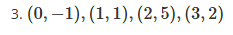
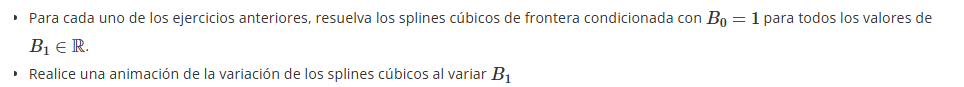

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import math

def clamped_cubic_spline_B1(n, x, a, B0, B1):
    """
    Calcula los coeficientes del spline cúbico condicionado con B0 y B1 especificados
    """
    # [El contenido de esta función permanece igual que antes]
    # Paso 1: Calcular h_i = x_{i+1} - x_i
    h = [x[i+1] - x[i] for i in range(n)]
    
    # Paso 2: Calcular alpha_0 y alpha_n especiales
    alpha = [0] * (n+1)
    alpha[0] = 3*(a[1] - a[0])/h[0] - 3*B0
    alpha[n] = 3*B1 - 3*(a[n] - a[n-1])/h[n-1]
    
    # Paso 3: Calcular alpha_i para i=1,...,n-1
    for i in range(1, n):
        alpha[i] = (3/h[i])*(a[i+1]-a[i]) - (3/h[i-1])*(a[i]-a[i-1])
    
    # Paso 4: Inicialización
    l = [0] * (n+1)
    mu = [0] * (n+1)
    z = [0] * (n+1)
    
    l[0] = 2*h[0]
    mu[0] = 0.5
    z[0] = alpha[0]/l[0]
    
    # Paso 5: Sustitución hacia adelante
    for i in range(1, n):
        l[i] = 2*(x[i+1] - x[i-1]) - h[i-1]*mu[i-1]
        mu[i] = h[i]/l[i]
        z[i] = (alpha[i] - h[i-1]*z[i-1])/l[i]
    
    # Paso 6: Preparar para sustitución hacia atrás
    l[n] = h[n-1]*(2 - mu[n-1])
    z[n] = (alpha[n] - h[n-1]*z[n-1])/l[n]
    c = [0] * (n+1)
    c[n] = z[n]
    
    # Paso 7: Sustitución hacia atrás
    b = [0] * n
    d = [0] * n
    
    for j in range(n-1, -1, -1):
        c[j] = z[j] - mu[j]*c[j+1]
        b[j] = (a[j+1] - a[j])/h[j] - h[j]*(c[j+1] + 2*c[j])/3
        d[j] = (c[j+1] - c[j])/(3*h[j])
    
    return [(a[j], b[j], c[j], d[j]) for j in range(n)]

def evaluate_spline(x, x_nodes, coefficients):
    """Evalúa el spline en el punto x"""
    for j in range(len(x_nodes)-1):
        if x_nodes[j] <= x <= x_nodes[j+1]:
            a, b, c, d = coefficients[j]
            dx = x - x_nodes[j]
            return a + b*dx + c*dx**2 + d*dx**3
    return 0

# Datos del problema
x_nodes = [0, 1, 2, 3]
y_values = [-1, 1, 5, 2]
B0 = 1
B1_values = np.linspace(-15, 15, 100)

# Configuración de la figura
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(-3, 8)
ax.grid(True, alpha=0.4)
ax.set_title('Spline Cúbico con Visualización de Tangente y Ángulo', fontsize=16, pad=20)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('S(x)', fontsize=14)

# Elementos gráficos
points = ax.plot(x_nodes, y_values, 'ro', markersize=10, label='Puntos de datos')[0]
spline_line, = ax.plot([], [], 'b-', lw=3, label='Spline cúbico')
tangent_line, = ax.plot([], [], 'g--', lw=2.5, label='Línea tangente')
angle_text = ax.text(3.1, 2, '', fontsize=12, color='darkgreen')
info_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12, 
                   bbox=dict(facecolor='white', alpha=0.9))

# Flecha para indicar la tangente (solo aparecerá cuando B1 no sea cero)
arrow = ax.annotate('', xy=(3, 2), xytext=(3, 2),
                    arrowprops=dict(arrowstyle='->', color='green', lw=2),
                    visible=False)

# Función para calcular el ángulo en grados
def calculate_angle(B1):
    return math.degrees(math.atan(B1))

# Función de inicialización
def init():
    spline_line.set_data([], [])
    tangent_line.set_data([], [])
    info_text.set_text('')
    angle_text.set_text('')
    arrow.set_visible(False)
    return spline_line, tangent_line, info_text, angle_text, arrow

# Función de animación
def animate(i):
    B1 = B1_values[i]
    coefficients = clamped_cubic_spline_B1(len(x_nodes)-1, x_nodes, y_values, B0, B1)
    
    # Actualizar spline
    x_plot = np.linspace(x_nodes[0], x_nodes[-1], 200)
    y_plot = [evaluate_spline(x, x_nodes, coefficients) for x in x_plot]
    spline_line.set_data(x_plot, y_plot)
    
    # Actualizar tangente
    x_tangent = np.linspace(2.7, 3.3, 2)  # Solo necesitamos 2 puntos para la línea
    y_tangent = y_values[-1] + B1*(x_tangent - x_nodes[-1])
    tangent_line.set_data(x_tangent, y_tangent)
    
    # Calcular ángulo y actualizar elementos visuales
    angle = calculate_angle(B1)
    angle_text.set_text(f'{angle:.1f}°')
    angle_text.set_position((3.1, y_values[-1] + 0.2))  # Ajustar posición vertical
    
    # Mostrar flecha cuando la pendiente es significativa
    if abs(B1) > 0.5:
        arrow.set_visible(True)
        dx = 0.3 if B1 > 0 else -0.3
        arrow.xy = (3 + dx, y_values[-1] + B1*dx)
        arrow.xyann = (3, y_values[-1])
    else:
        arrow.set_visible(False)
    
    # Actualizar texto informativo
    info_text.set_text(f'Configuración actual:\nB0 (x=0) = {B0}\nB1 (x=3) = {B1:.2f}\nÁngulo = {angle:.1f}°')
    
    return spline_line, tangent_line, info_text, angle_text, arrow

# Crear animación
ani = FuncAnimation(fig, animate, frames=len(B1_values),
                    init_func=init, blit=True, interval=100)

# Configurar leyenda
legend = ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99), 
                  framealpha=0.95, fontsize=12)
legend.get_frame().set_facecolor('white')

plt.tight_layout()
plt.close()

HTML(ani.to_jshtml())